# Sparkify Project Workspace

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This notebook is used to explore a smaller subset with Spark. I chose not to run the notebook in the cloud.

In [1]:
! spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.4.1
      /_/
                        
Using Scala version 2.12.17, OpenJDK 64-Bit Server VM, 11.0.20.1
Branch HEAD
Compiled by user centos on 2023-06-19T23:01:01Z
Revision 6b1ff22dde1ead51cbf370be6e48a802daae58b6
Url https://github.com/apache/spark
Type --help for more information.


In [2]:
!pip install --upgrade scikit-learn

In [3]:
!pip install --upgrade seaborn matplotlib 

In [4]:
# Import necessary libraries
import random
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from time import time

# Spark related imports
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import ( col, lit,
    avg, count, desc, asc, max, udf, isnan, sum as Fsum
)
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import ( VectorAssembler,MinMaxScaler)
from sklearn.metrics import classification_report
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import precision_recall_curve, auc


# Ensure matplotlib plots are displayed inline
%matplotlib inline
random.seed(42)


In [5]:
# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Set the log level for the specific logger to ERROR
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org.apache.spark.scheduler.DAGScheduler").setLevel(logger.Level.ERROR)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/19 10:25:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Section 1: Load and Clean Dataset

## 1.1 Data Loading

In [6]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### 1.2. Check missing values

In [8]:
# Examine the number of missing values in each column
total_rows = df.count()
print(f"Total number of rows in the dataset: {total_rows}.\n")

for col_name in df.columns:
    missing_count = df.filter((isnan(df[col_name])) | (df[col_name].isNull()) | (df[col_name] == "")).count()
    nan_count = df.filter(isnan(df[col_name])).count()
    null_count = df.filter(df[col_name].isNull()).count()
    empty_str_count = df.filter(df[col_name] == "").count()
    
    print(f"{col_name}: {missing_count} missing values.")
    print(f"    {nan_count} NaN's; {null_count} Null's; {empty_str_count} empty strings.\n")


Total number of rows in the dataset: 286500.

artist: 58392 missing values.
    0 NaN's; 58392 Null's; 0 empty strings.

auth: 0 missing values.
    0 NaN's; 0 Null's; 0 empty strings.

firstName: 8346 missing values.
    0 NaN's; 8346 Null's; 0 empty strings.

gender: 8346 missing values.
    0 NaN's; 8346 Null's; 0 empty strings.

itemInSession: 0 missing values.
    0 NaN's; 0 Null's; 0 empty strings.

lastName: 8346 missing values.
    0 NaN's; 8346 Null's; 0 empty strings.

length: 58392 missing values.
    0 NaN's; 58392 Null's; 0 empty strings.

level: 0 missing values.
    0 NaN's; 0 Null's; 0 empty strings.

location: 8346 missing values.
    0 NaN's; 8346 Null's; 0 empty strings.

method: 0 missing values.
    0 NaN's; 0 Null's; 0 empty strings.

page: 0 missing values.
    0 NaN's; 0 Null's; 0 empty strings.

registration: 8346 missing values.
    0 NaN's; 8346 Null's; 0 empty strings.

sessionId: 0 missing values.
    0 NaN's; 0 Null's; 0 empty strings.

song: 58392 missing

#### Handling missing values in `userId` and `sessionId`

In [9]:
# Remove rows with NaN values in either userId or sessionId
initial_row_count = df.count()
print(f"Initial row count: {initial_row_count}")

df = df.dropna(how='any', subset=['userId', 'sessionId'])

final_row_count = df.count()
removed_rows = initial_row_count - final_row_count

print(f"Rows with NaN values in either userId or sessionId removed: {removed_rows}")
print(f"Remaining rows in the dataset: {final_row_count}")


Initial row count: 286500
Rows with NaN values in either userId or sessionId removed: 0
Remaining rows in the dataset: 286500


In [10]:
# Preview unique userId values
unique_userIds = df.select(['userId']).dropDuplicates().orderBy(df['userId'])
unique_userIds.show(5)


+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



A `userId` with an empty string appears unusual. To investigate further, I will analyze the `page` events associated with empty `userId` values in comparison to all other `userId` values.

In [11]:
# Create a view to run SQL queries
df.createOrReplaceTempView("df_table")

In [12]:
# page events of users whose userId IS an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|              Login|
|               Help|
|              Error|
|Submit Registration|
|           Register|
+-------------------+



In [13]:
# page events of users whose userId is NOT an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId != ""
    '''
).show()

+--------------------+
|                page|
+--------------------+
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
|              Cancel|
|Cancellation Conf...|
+--------------------+



An empty string in the `userId` likely indicates users who are in the process of signing in or registering. Consequently, we will remove the rows associated with empty `userId` values.

In [14]:
# Drop rows that have empty userId
df = df.filter(df['userId'] != "")

Since the `sessionId` column contains numeric values, we don't need to be concerned about empty string issues in this column.

In [15]:
# Check the number of missing values in selected columns
print("Number of missing values:")
selected_columns = ['userId', 'sessionId', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']

for col_name in selected_columns:
    missing_count = df.filter((isnan(df[col_name])) | (df[col_name].isNull()) | (df[col_name] == "")).count()
    print(f"    {col_name}: {missing_count} missing values.")


Number of missing values:


    userId: 0 missing values.
    sessionId: 0 missing values.
    firstName: 0 missing values.
    gender: 0 missing values.
    lastName: 0 missing values.
    location: 0 missing values.
    registration: 0 missing values.
    userAgent: 0 missing values.


#### Handling missing values in `artist`, `length`, `song`

In [16]:
# Page events with null artist values
null_artist_pages = df.filter(df['artist'].isNull()).select(df['page']).dropDuplicates()
null_artist_pages.show()


+--------------------+
|                page|
+--------------------+
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
|              Cancel|
|Cancellation Conf...|
+--------------------+



In [17]:
# Page events with not null artist values
not_null_artist_pages = df.filter(df['artist'].isNotNull()).select(df['page']).dropDuplicates()
not_null_artist_pages.show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



It appears that the 'NextSong' page event, which corresponds to playing a song, is the only event with associated information in the `artist`, `length`, and `song` columns. This alignment makes sense.

In [18]:
# Check the number of missing values in artist, length, and song columns when the page event is "NextSong"
df_song = df.filter(df['page'] == "NextSong")

print("When page event is 'NextSong':")
selected_columns = ['artist', 'length', 'song']

for col_name in selected_columns:
    missing_count = df_song.filter((isnan(df[col_name])) | (df[col_name].isNull()) | (df[col_name] == "")).count()
    print(f"    {col_name}: {missing_count} missing values.")


When page event is 'NextSong':


    artist: 0 missing values.
    length: 0 missing values.
    song: 0 missing values.


# Section 2: Exploratory Data Analysis (EDA)
Let's begin our Exploratory Data Analysis (EDA) using a small subset of the full dataset.

In [19]:
# Create a substitute of the dataset
df_sub = df


### 2.1. Summary Statistics for Numeric Columns

In [20]:
# Numerical columns (except for sessionId)
num_cols = ['itemInSession', 'registration', 'status', 'ts', 'length']
# Describe numerical columns (except for sessionId)
df_sub.select(num_cols).describe().show()

23/09/19 10:26:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------------------+------------------+--------------------+------------------+
|summary|     itemInSession|        registration|            status|                  ts|            length|
+-------+------------------+--------------------+------------------+--------------------+------------------+
|  count|            278154|              278154|            278154|              278154|            228108|
|   mean|114.89918174824018|1.535358834085557...|209.10321620397335|1.540958915431858E12|249.11718197783486|
| stddev| 129.8517293994901| 3.291321616327451E9|30.151388851327837|1.5068287123357651E9| 99.23517921058333|
|    min|                 0|       1521380675000|               200|       1538352117000|           0.78322|
|    max|              1321|       1543247354000|               404|       1543799476000|        3024.66567|
+-------+------------------+--------------------+------------------+--------------------+------------------+



In [21]:
# Possible values of 'status'
col = 'status'
distinct_values = df_sub.select(col).distinct().rdd.flatMap(lambda x: x).collect()

print(f"Possible values of '{col}':")
print(distinct_values)


Possible values of 'status':
[307, 404, 200]


Since the `status` values lack a continuous meaning, I will treat the `status` column as a categorical variable.

### 2.2. Exploring non-numerical columns


In [22]:
# Non-numerical columns (except for userId)
cat_cols = ['artist', 'auth', 'firstName', 'lastName', 'gender', 'level', 'location',
            'method', 'page', 'song', 'userAgent']

In [23]:
# Possible values of 'auth'
coln = 'auth'
distinct_values = df_sub.select(coln).distinct().rdd.flatMap(lambda x: x).collect()

print(f"Possible values of '{coln}':")
print(distinct_values)


Possible values of 'auth':
['Logged In', 'Cancelled']


In [24]:
# Possible values of 'gender'
coln = 'gender'
distinct_values = df_sub.select(coln).distinct().rdd.flatMap(lambda x: x).collect()

print(f"Possible values of '{coln}':")
print(distinct_values)


Possible values of 'gender':
['F', 'M']


In [25]:
# Possible values of 'level'
coln = 'level'
distinct_values = df_sub.select(coln).distinct().rdd.flatMap(lambda x: x).collect()

print(f"Possible values of '{coln}':")
print(distinct_values)


Possible values of 'level':
['free', 'paid']


In [26]:
# Possible values of 'method'
coln = 'method'
distinct_values = df_sub.select(coln).distinct().rdd.flatMap(lambda x: x).collect()

print(f"Possible values of '{coln}':")
print(distinct_values)


Possible values of 'method':
['PUT', 'GET']


In [27]:
# Possible values of 'page'
coln = 'page'
distinct_values = df_sub.select(coln).distinct().rdd.flatMap(lambda x: x).collect()

print(f"Possible values of '{coln}':")
print(distinct_values)


Possible values of 'page':
['Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade', 'Cancel', 'Cancellation Confirmation']


In [28]:
# Possible values of 'userAgent'
coln = 'userAgent'
distinct_values = df_sub.select(coln).distinct().rdd.flatMap(lambda x: x).collect()[:10]

print(f"Possible values of '{coln}' (first 10 values):")
print(distinct_values)


Possible values of 'userAgent' (first 10 values):
['"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0', 'Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)', '"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53"', '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', 'Mozilla/5.0 (Windows NT 6.1; W

In [29]:
# A status of 404 corresponds to a page event "Error"
df_sub.select(['status', 'page']).where(df_sub['status']==404).dropDuplicates().show()

+------+-----+
|status| page|
+------+-----+
|   404|Error|
+------+-----+



### 2.3. Define churn

In order to label `Churn` for our model, we'll introduce a new column called `Churn`. `Churn` will be determined by the occurrence of Cancellation Confirmation events, which can happen for both paid and free users. In this context, we define churn as the state where a user no longer actively uses the music service, regardless of whether they were a free or paid user.

In [30]:
# Define a user-defined function (UDF) to flag churn events
def flag_churn_event(page):
    return 1 if page == "Cancellation Confirmation" else 0

# Register the UDF
flag_churn_udf = udf(flag_churn_event, IntegerType())

# Add a new column 'churned' to the DataFrame
df_sub = df_sub.withColumn("churned", flag_churn_udf(df_sub["page"]))

In [31]:
# Calculate the percentage of users who churned
total_users = df_sub.select('userId').distinct().count()
churned_users = df_sub.filter(df_sub['churned'] == 1).select('userId').distinct().count()

percentage_churned = (churned_users / total_users) * 100

print(f"{round(percentage_churned, 1)}% of users have churned.")

23.1% of users have churned.


In [32]:
# Calculate flags of churn
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# 1 means the user has already churned at this timestamp
df_sub = df_sub.withColumn("churnPhase", Fsum('churned').over(windowval))

# 1 means the user is a churn user
df_sub = df_sub.withColumn("churnUser", max('churned').over(Window.partitionBy("userId")))

In [33]:
df_sub.select('churned').distinct().show()

+-------+
|churned|
+-------+
|      0|
|      1|
+-------+



### 2.4. EDA on churn and non-churn 

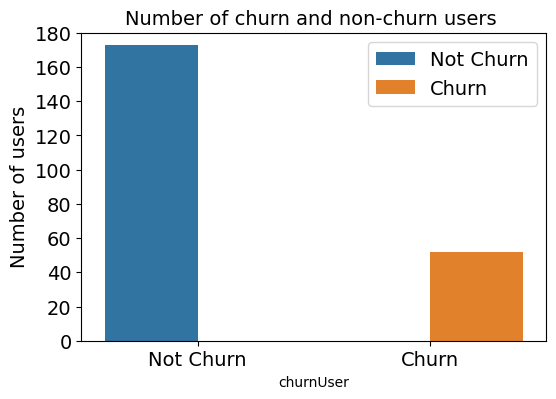

In [34]:
# Visualize the number of users and if they churned or not
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
churn_users_pd = df_sub.select(['userId', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.countplot(x="churnUser", hue="churnUser", data=churn_users_pd,
#                palette=['steelblue', 'orange'], ci=None,
);
plt.ylim(0, 180)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of churn and non-churn users ", fontsize=14)
plt.legend(loc='best', fontsize=14);



### process data for datetime analysis 

In [35]:
# Calculate the hour, day, weekday of the timestamp ts
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_sub = df_sub.withColumn("hour", get_hour(df_sub.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_sub = df_sub.withColumn("day", get_day(df_sub.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_sub = df_sub.withColumn("weekday", get_weekday(df_sub.ts))

# Calculate occurance of pageDowngrade
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_sub = df_sub.withColumn("pageDowngrade", flag_downgrade_event("page"))

# Calculate flags of downgrade; 1 means has downgraded from paid to free
df_sub = df_sub.withColumn("pageDowngradePhase", Fsum('pageDowngrade').over(windowval))

In [36]:
# Create a view to run SQL queries
df_sub.createOrReplaceTempView("df_sub_table")

#### Churn vs Gender 

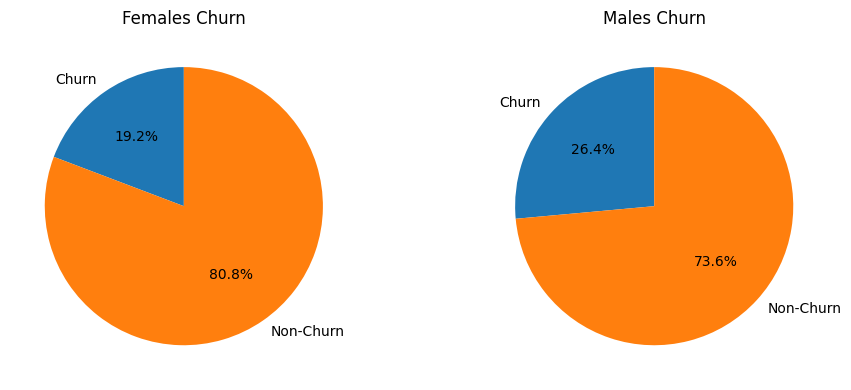

In [37]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
gender_users_pd = df_sub.select(['userId', 'Gender', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()
Females = gender_users_pd[gender_users_pd['Gender']=='F']
Males  = gender_users_pd[gender_users_pd['Gender']=='M']

# Calculate the percentage of churn users for each DataFrame
total_females = len(Females)
churned_females = (Females['churnUser'] == 'Churn').sum()
percentage_churn_females = (churned_females / total_females) * 100

total_males = len(Males)
churned_males = (Males['churnUser'] == 'Churn').sum()
percentage_churn_males = (churned_males / total_males) * 100

# Data for the pie charts
labels = ['Churn', 'Non-Churn']
sizes_females = [percentage_churn_females, 100 - percentage_churn_females]
sizes_males = [percentage_churn_males, 100 - percentage_churn_males]

# Get the default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a figure with two subplots (one for each pie chart)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first pie chart (Females) using default colors
axes[0].pie(sizes_females, labels=labels, autopct='%1.1f%%', startangle=90, colors=default_colors)
axes[0].set_title('Females Churn')
axes[0].set_aspect('equal')  # Set aspect ratio to 'equal'

# Plot the second pie chart (Males) using default colors
axes[1].pie(sizes_males, labels=labels, autopct='%1.1f%%', startangle=90, colors=default_colors)
axes[1].set_title('Males Churn')
axes[1].set_aspect('equal')  # Set aspect ratio to 'equal'

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the pie charts
plt.show()

we can see that males churn slightly more than females 

#### Churn on weekdays

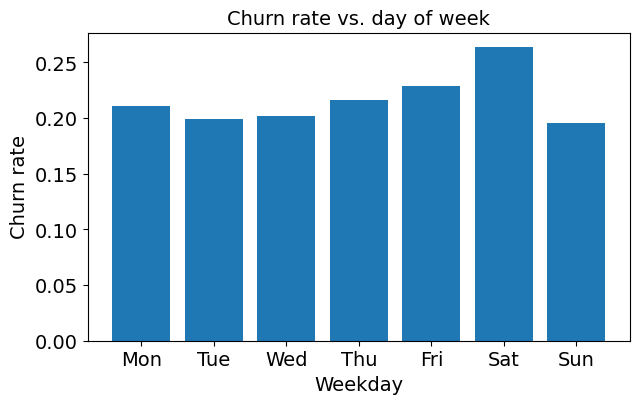

In [38]:
# Calculate day counts
daily = df_sub.select(['userId', 'weekday', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('weekday')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
daily_df = daily.toPandas()

# Visualize weekday patterns
plt.figure(figsize=(7,4))
plt.bar(daily_df['weekday'], daily_df['num_churns'] / daily_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Churn rate vs. day of week", fontsize=14);

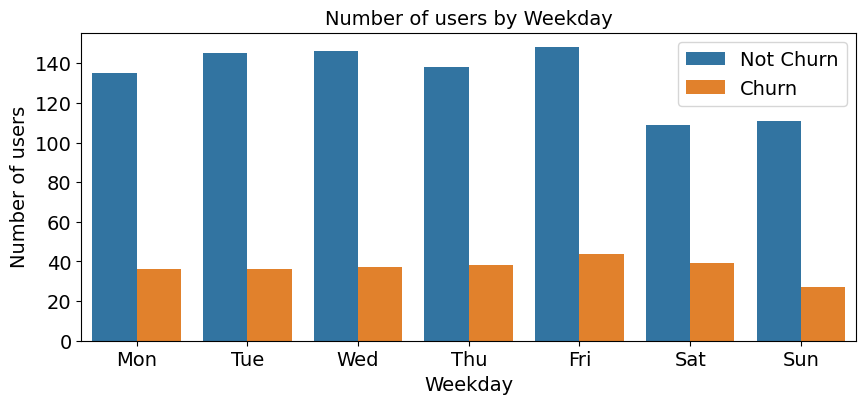

In [39]:
# Visualize the number of users by weekday
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
weekday_users_pd = df_sub.select(['userId', 'weekday', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="weekday", hue="churnUser", data=weekday_users_pd,
              hue_order=['Not Churn', 'Churn']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users by Weekday", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(loc='best', fontsize=14);

 Saturday has highest churn rate. churn users use the services on fridays the most, this suggests that the Friday users cohort are more likely to churn.

#### Churn vs. level

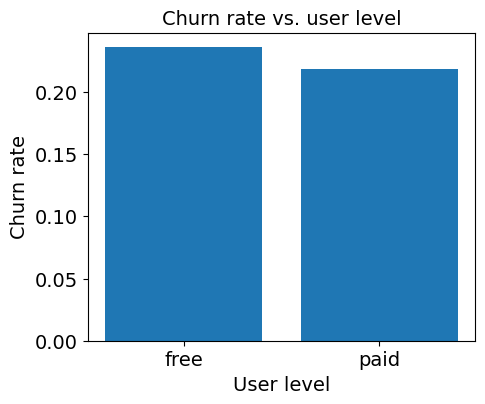

In [40]:
# Calculate churns by level
levels = df_sub.select(['userId', 'level', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('level')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
levels_df = levels.toPandas()

# Visualize level patterns
plt.figure(figsize=(5,4))
plt.bar(levels_df['level'], levels_df['num_churns'] / levels_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User level", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user level", fontsize=14);

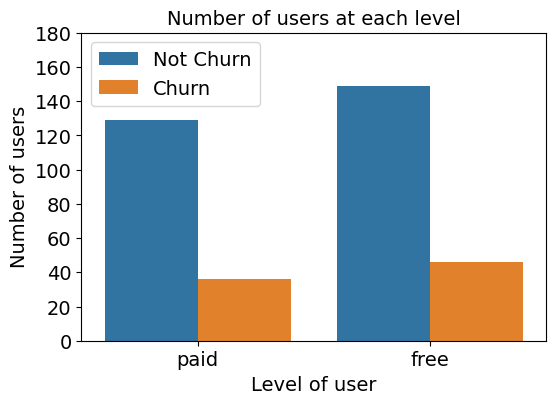

In [41]:
# Visualize the number of users by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_users_pd = df_sub.select(['userId', 'level', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.countplot(x="level", hue="churnUser", data=level_users_pd,
#                palette=['steelblue', 'orange'], ci=None,
);
plt.ylim(0, 180)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Level of user", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users at each level", fontsize=14)
plt.legend(loc='best', fontsize=14);

<Figure size 600x400 with 0 Axes>

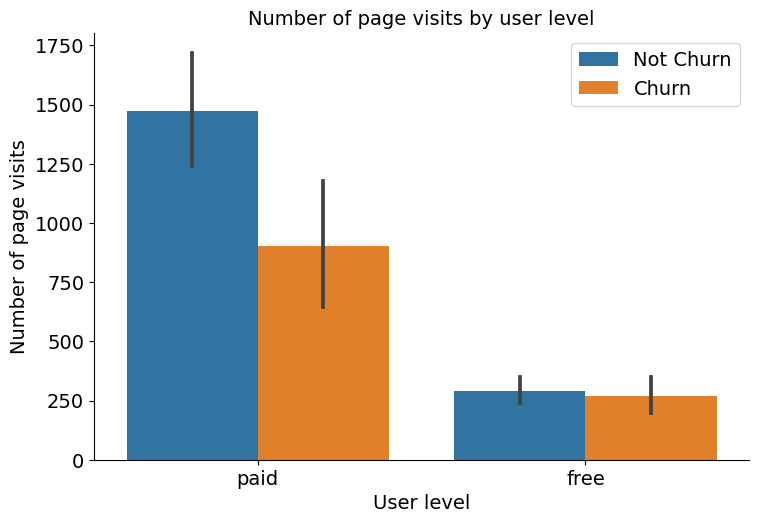

In [42]:
# Visualize the usage (i.e. the number of page events) by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_usage_pd = df_sub.groupBy(['userId', 'level']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.catplot(x="level", y="count(page)", hue="max(churnUser)", data=level_usage_pd,
#                palette=['steelblue', 'orange'], ci=None,
               kind="bar", aspect=1.5, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User level", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits by user level", fontsize=14)
plt.legend(loc='best', fontsize=14);

 There are more free users than paid users, and the free users are slightly more likely to churn.
 and overall churn users use the service less than non-churn users 

#### Churn vs. page events

In [43]:
# Create pivot table of page events
pages = df_sub.groupBy(['userId']).pivot('page').count().fillna(0)
pages_df = pages.toPandas()

pages_df = pages_df.rename(columns={"Cancellation Confirmation": "Churn"})
pages_df.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
1,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0
4,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0


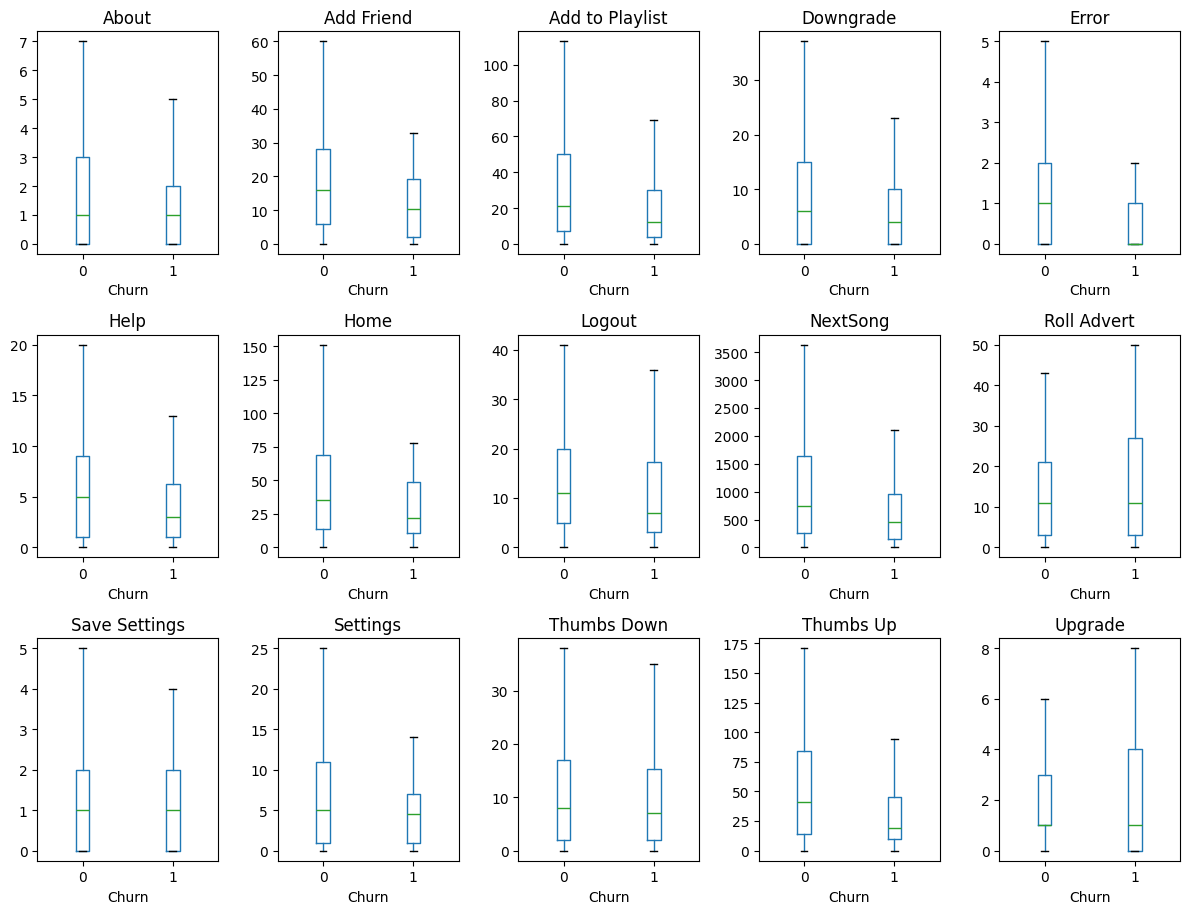

In [44]:
# Visualize churn patterns by page event
fig = plt.figure(figsize=(12, 12))
cols_interest = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 
                 'Thumbs Up', 'Upgrade']

for i, coln in enumerate(cols_interest):
    ax = fig.add_subplot(4,5,i+1)
    pages_df.boxplot(coln, ax=ax, grid=False,  by='Churn', showfliers=False);

fig.suptitle('')
plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

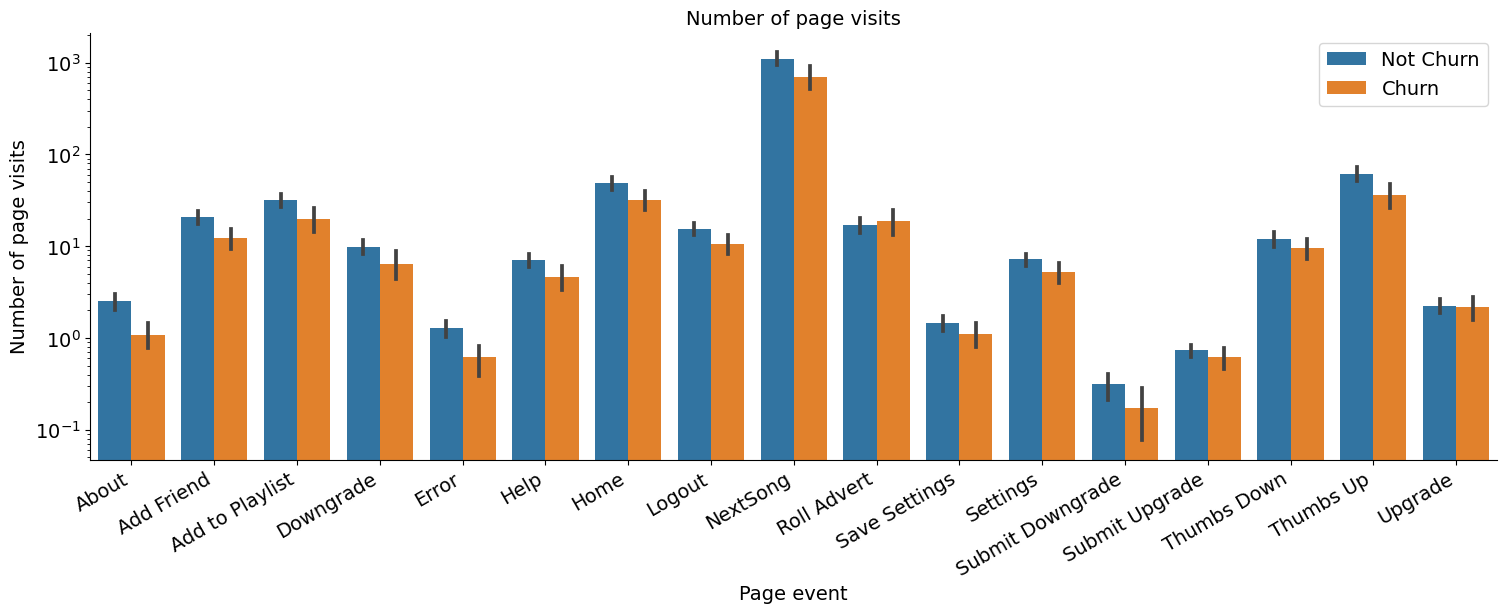

In [45]:
# Visualize the distribution of page events
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
pages_df = pages_df.drop('Cancel', axis=1)

page_events_pd = pd.melt(
    pages_df, id_vars=['userId', 'Churn'], 
    value_vars=list(pages_df.columns[1:].drop('Churn')),
    var_name='page', 
    value_name='number_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.catplot(x="page", y="number_visits", hue="Churn", data=page_events_pd,
               kind="bar", aspect=3, legend=False, log=True);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

In general, churn users have less engagement (number of page events) than no-churn users. Churn users have generally added less friends, added less playlist, requested less help, listened less songs, and given less thumbs ups than thumbs downs. Interestingly, churn users have also encountered less errors, which on a second thought makes sense because churn users genrally engage less with Spotify and have less chances to encounter errors.

<Figure size 1000x600 with 0 Axes>

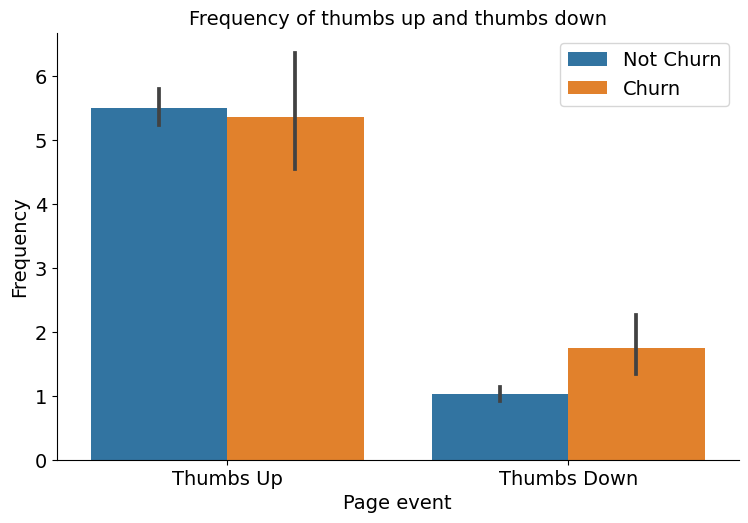

In [46]:
# Visualize the frequency of thumbs up vs. thumbs down
pages_df['Thumbs Up Frequency'] = pages_df['Thumbs Up'] / pages_df['NextSong'] * 100
pages_df['Thumbs Down Frequency'] = pages_df['Thumbs Down'] / pages_df['NextSong'] * 100

page_events_pd2 = pd.melt(
    pages_df[['userId', 'Churn', 'Thumbs Up Frequency', 'Thumbs Down Frequency']], 
    id_vars=['userId', 'Churn'], 
    value_vars=['Thumbs Up Frequency', 'Thumbs Down Frequency'],
    var_name='page', 
    value_name='ratio'
).reset_index()
page_events_pd2['page'] = page_events_pd2['page']\
    .replace({"Thumbs Up Frequency": "Thumbs Up", 
              "Thumbs Down Frequency": "Thumbs Down"})

fig = plt.figure(figsize=(10, 6))
sns.catplot(x="page", y="ratio", hue="Churn", data=page_events_pd2,
               kind="bar", aspect=1.5, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Frequency of thumbs up and thumbs down", fontsize=14)
plt.legend(loc='best', fontsize=14);

This shows that churn users use the Thumbs-Down more than non-churn 

#### Churn vs. device used

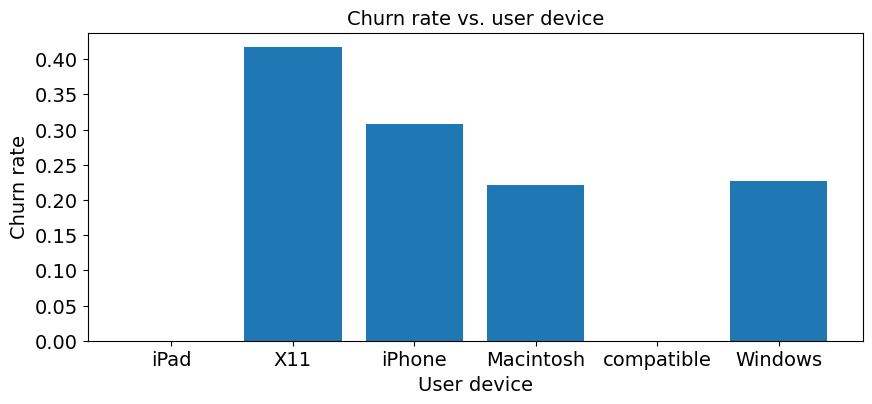

In [47]:
# Calculate churns by device
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
df_sub_device.createOrReplaceTempView("df_sub_device_table")

device = df_sub_device.select(['userId', 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('userAgent')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
device_df = device.toPandas()

# Visualize device patterns
plt.figure(figsize=(10,4))
plt.bar(device_df['userAgent'], device_df['num_churns'] / device_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User device", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user device", fontsize=14);

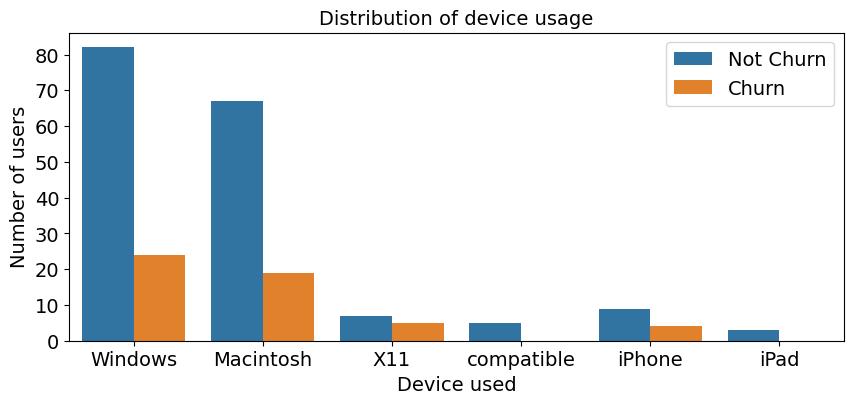

In [48]:
# Calculate churns by device
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
device_pd = df_sub_device.select(["userId", 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="userAgent", hue="churnUser", data=device_pd);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Device used", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Distribution of device usage", fontsize=14)
plt.legend(loc='best', fontsize=14);

This doesnt show clear correlation between the device and a user being churn 

## 3. Feature Engineering

In this section, I'm going to build out the features that I think useful to train my model on. First, I'm going to do pilot study on a small subset of the full dataset. Then, I will use the code on the full dataset.

Choose a subset of the dataset to start with.

### 3.1. Create features on per user basis

Features to create on per user basis:

- `page-Cancellation Confirmation`: Churn (binary)

- `registration` and `ts`: Time since registration in seconds
- `gender`: Gender, "M"->1, "F"->0 (binary)
- `level`: Level of user most recently, "paid"->1, "free"->0 (binary)

- `artist`: Total number of unique artists the user has listened to (int)
- `length`: Total length of songs listened (float)
- `sessionId`: Total number of sessions (int)
- `song`: Total number of songs the user has listened to (int)
- `song`: Total number of unique songs the user has listened to (int)

- `artist` and `song`: Statistics of the number of songs per artist that the user has listened to (float)

- `sessionId` and `ts`: Statistics of the time spent per session (float)
- `sessionId` and `song`: Statistics of the number of songs per session (float)

- `userAgent`: User agents (binary)
- `page`: Number of page events (int)
    - Thumbs Up, Thumbs Down, Home, Roll Advert, Logout, Save Settings, About, Settings, Add to Playlist, Add Friend, NextSong, Help, Error, Submit Upgrade, Submit Downgrade
- `location`: First listed location state (binary)

In [49]:
df_sub2 = df

In [50]:
df_sub2.createOrReplaceTempView("df_sub2_table")

#### Define churn

In [51]:
# Define churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df_sub2.withColumn("churned", flag_churn_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(max('churned').alias("churn"))

print(f"{churn.count()} rows.")
print(f"{round(churn.select(avg('churn')).collect()[0]['avg(churn)']*100, 1)}% users churned.")
churn.show(5)

225 rows.


23.1% users churned.
+------+-----+
|userId|churn|
+------+-----+
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
|    15|    0|
+------+-----+
only showing top 5 rows



#### Latest level of user

In [52]:
# Latest level
func_levels = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
levels = df_sub2.select(['userId', 'level', 'ts'])\
    .orderBy(desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'level'])\
    .withColumn('level', func_levels('level').cast(IntegerType()))

print(f"{levels.count()} rows.")
levels.show(5)

225 rows.
+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



#### Time since registration, and gender of user

In [53]:
# Time since registration in seconds, and gender as binary
time_gender = spark.sql(
    '''
    SELECT userId, (MAX(ts) - AVG(registration)) / 1000 time_since_regi,
    AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender
    FROM df_sub2_table
    GROUP BY userId
    '''
)

print(f"{time_gender.count()} rows.")
time_gender.show(5)

225 rows.
+------+---------------+------+
|userId|time_since_regi|gender|
+------+---------------+------+
|    51|      1680985.0|   1.0|
|   124|    1.1366431E7|   0.0|
|     7|      6288035.0|   1.0|
|    54|      9568946.0|   0.0|
|    15|      4882773.0|   1.0|
+------+---------------+------+
only showing top 5 rows



#### Number of artists, total length, number of sessions, and number of songs that the user has engaged

In [54]:
# Number of artists, total length, number of sessions, number of songs, and number of page events
# that the user has engaged
engagement = spark.sql(
    '''
    SELECT userId, COUNT(DISTINCT artist) num_artists_dist, 
    SUM(length) tot_length, COUNT(DISTINCT sessionId) num_sessions, 
    COUNT(song) num_songs, COUNT(DISTINCT song) num_songs_dist,
    COUNT(page) num_events
    FROM df_sub2_table
    GROUP BY userId
    '''
)

print(f"{engagement.count()} rows.")
engagement.show(5)

225 rows.


+------+----------------+------------------+------------+---------+--------------+----------+
|userId|num_artists_dist|        tot_length|num_sessions|num_songs|num_songs_dist|num_events|
+------+----------------+------------------+------------+---------+--------------+----------+
|100010|             252|       66940.89735|           7|      275|           269|       381|
|200002|             339| 94008.87593999997|           6|      387|           378|       474|
|   125|               8|2089.1131000000005|           1|        8|             8|        11|
|   124|            2232|1012312.0927899999|          29|     4079|          3339|      4825|
|    51|            1385|523275.84280000004|          10|     2111|          1854|      2464|
+------+----------------+------------------+------------+---------+--------------+----------+
only showing top 5 rows



#### Statistics of the number of songs per artist that the user has listened to

In [55]:
# Statistics of the number of songs per artist that the user has listened to
per_artist = spark.sql(
    '''
    SELECT userId, MAX(num_songs) max_songs_per_artist, 
    AVG(num_songs) avg_songs_per_artist, stddev_samp(num_songs) std_songs_per_artist
    FROM
        (SELECT userId, artist, COUNT(song) as num_songs
        FROM df_sub2_table
        WHERE (artist IS NOT NULL)
        GROUP BY userId, artist) songs_per_artist
    GROUP BY userId
    '''
).fillna(0)

print(f"{per_artist.count()} rows.")
per_artist.show(5)

225 rows.
+------+--------------------+--------------------+--------------------+
|userId|max_songs_per_artist|avg_songs_per_artist|std_songs_per_artist|
+------+--------------------+--------------------+--------------------+
|100010|                   3|  1.0912698412698412| 0.32737513145684877|
|200002|                   4|  1.1415929203539823|  0.4255297423289412|
|    51|                  15|  1.5241877256317689|  1.4120250777606445|
|   124|                  37|  1.8275089605734767|   2.373901024354071|
|     7|                   2|   1.056338028169014| 0.23138950880438983|
+------+--------------------+--------------------+--------------------+
only showing top 5 rows



#### Statistics of the time spent and the number of songs per session

In [56]:
# Statistics of the time spent and the number of songs per session (float)
per_session = spark.sql(
    '''
    SELECT userId, MAX(num_songs) max_songs_per_session, 
    AVG(num_songs) avg_songs_per_session, stddev_samp(num_songs) std_songs_per_session,
    MAX(time) max_time_per_session, AVG(time) avg_time_per_session, 
    stddev_samp(time) std_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM df_sub2_table
        GROUP BY userId, sessionId) per_session
    GROUP BY userId
    '''
).fillna(0)

print(f"{per_session.count()} rows.")
per_session.show(1)

225 rows.
+------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+
|userId|max_songs_per_session|avg_songs_per_session|std_songs_per_session|max_time_per_session|avg_time_per_session|std_time_per_session|
+------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+
|100010|                   80|   39.285714285714285|   22.961665776639446|             19380.0|              9269.0|   5719.952913559108|
+------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+
only showing top 1 row



#### Calculate usage of each userAgent

In [57]:

def func_agent_device(x): 
    try:
        return "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0]
    except: 
        return 'user_agent_unknown'
        
func_agent_device2 = udf(lambda x : func_agent_device(x))

In [58]:
from pyspark.sql.functions import (
    avg, col, concat, count, desc, asc, explode, lit,
    min, max, split, stddev, udf, isnan, when, rank,
    log, sqrt, cbrt, exp, sum as Fsum
)

In [59]:

# Calculate usage fraction of each userAgent
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

agents = df_sub2.withColumn("userAgent", lit(func_agent_device2(df_sub2["userAgent"])))\
    .select(["userId", 'userAgent'])\
    .groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage"))\
    .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)

print(f"{agents.count()} rows.")
agents.show(5)


225 rows.
+------+--------------------+------------------+--------------+---------------------+---------------+-----------------+
|userId|user_agent_Macintosh|user_agent_Windows|user_agent_X11|user_agent_compatible|user_agent_iPad|user_agent_iPhone|
+------+--------------------+------------------+--------------+---------------------+---------------+-----------------+
|    10|                 1.0|               0.0|           0.0|                  0.0|            0.0|              0.0|
|   100|                 0.0|               1.0|           0.0|                  0.0|            0.0|              0.0|
|100001|                 1.0|               0.0|           0.0|                  0.0|            0.0|              0.0|
|100002|                 0.0|               1.0|           0.0|                  0.0|            0.0|              0.0|
|100003|                 0.0|               1.0|           0.0|                  0.0|            0.0|              0.0|
+------+--------------------+-

#### Calculate the count and fraction of each page event by each user

In [60]:
# Count usages of each page event by each user
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']
func_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())

pages = df_sub2.filter(~df_sub2['page'].isin(pages_to_exclude))\
    .withColumn("page", func_pages(df_sub2["page"]))\
    .groupBy(['userId']).pivot("page").agg(count('page'))\
    .fillna(0)
pages = pages.withColumn("page_up_down_ratio", pages["page_thumbs_up"]/(pages['page_thumbs_down']+0.1))

print(f"{pages.count()} rows.")
pages.show(2)

225 rows.
+------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+
|userId|page_about|page_add_friend|page_add_to_playlist|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_save_settings|page_settings|page_submit_downgrade|page_submit_upgrade|page_thumbs_down|page_thumbs_up|page_up_down_ratio|
+------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+
|100010|         1|              4|                   7|         0|        2|       11|          5|          275|              52|                 0|            0|                    0|                  0|              

In [61]:
# Calculate the fraction of each page event by each user
pages = pages.withColumn(
    'total', lit(0))

columns_to_sum = []
for coln in pages.columns: 
    if (coln != 'userId') and (coln != 'page_up_down_ratio'):
        columns_to_sum.append(coln)

for coln in columns_to_sum :
    pages = pages.withColumn('total', col('total') + col(coln) )


In [62]:

for coln in pages.columns:
    if coln not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = coln[0:5]+'frac_'+coln[5:]
        pages = pages.withColumn(new_col_name, pages[coln] / pages['total'])

pages = pages.drop('total')
print(f"{pages.count()} rows.")
pages.select([coln for coln in pages.columns if '_frac' in coln]).show(2)

225 rows.
+--------------------+--------------------+-------------------------+---------------+--------------------+--------------------+--------------------+------------------+---------------------+-----------------------+--------------------+--------------------------+------------------------+---------------------+--------------------+
|     page_frac_about|page_frac_add_friend|page_frac_add_to_playlist|page_frac_error|      page_frac_help|      page_frac_home|    page_frac_logout|page_frac_nextsong|page_frac_roll_advert|page_frac_save_settings|  page_frac_settings|page_frac_submit_downgrade|page_frac_submit_upgrade|page_frac_thumbs_down| page_frac_thumbs_up|
+--------------------+--------------------+-------------------------+---------------+--------------------+--------------------+--------------------+------------------+---------------------+-----------------------+--------------------+--------------------------+------------------------+---------------------+--------------------+


#### Join engineered features together

In [63]:
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(engagement, ['userId'])\
    .join(per_artist, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])

dataset.head()

Row(userId='10', churn=0, level=1, time_since_regi=4472293.0, gender=1.0, num_artists_dist=565, tot_length=166866.37250999996, num_sessions=6, num_songs=673, num_songs_dist=629, num_events=795, max_songs_per_artist=9, avg_songs_per_artist=1.191150442477876, std_songs_per_artist=0.6459856290976529, max_songs_per_session=381, avg_songs_per_session=112.16666666666667, std_songs_per_session=133.32429136007687, max_time_per_session=92875.0, avg_time_per_session=27584.833333333332, std_time_per_session=32367.821189673345, user_agent_Macintosh=1.0, user_agent_Windows=0.0, user_agent_X11=0.0, user_agent_compatible=0.0, user_agent_iPad=0.0, user_agent_iPhone=0.0, page_about=2, page_add_friend=12, page_add_to_playlist=9, page_error=0, page_help=1, page_home=30, page_logout=11, page_nextsong=673, page_roll_advert=1, page_save_settings=1, page_settings=7, page_submit_downgrade=0, page_submit_upgrade=0, page_thumbs_down=4, page_thumbs_up=37, page_up_down_ratio=9.02439024390244, page_frac_about=0.00

In [64]:
print(f"{dataset.count()} rows.")


225 rows.


### 3.2. Check multicollinearity

Remove features that are strongly correlated to others.

In [65]:
# Convert to pandas
dataset_pd = dataset.toPandas()

Correlations among the features:


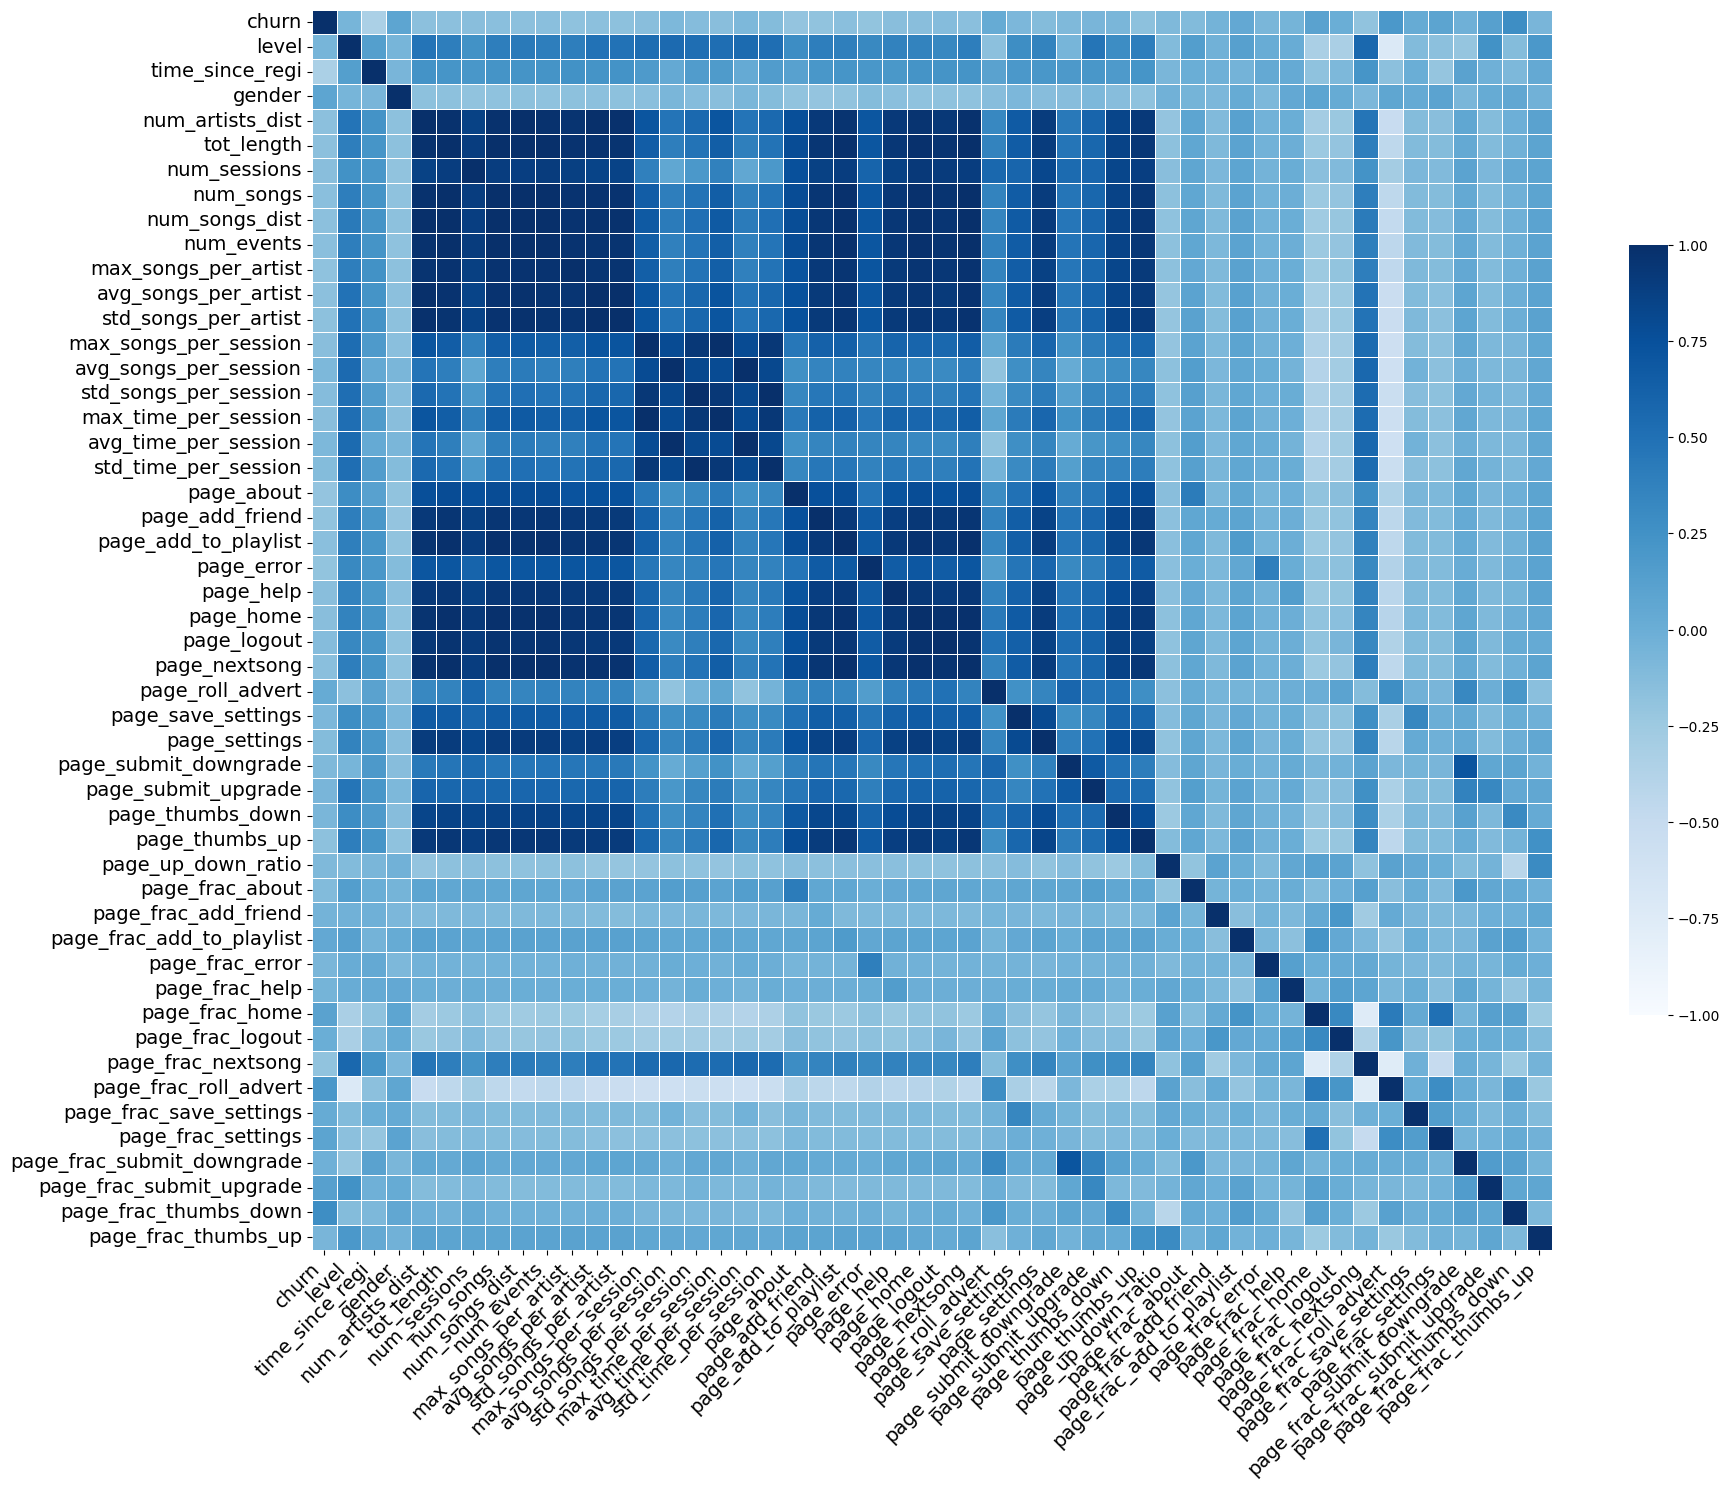

In [66]:
# Visualize correlations of the remaining features
print("Correlations among the features:")
cols_to_keep_corr = [coln for coln in dataset_pd.columns if ('user_agent' not in coln) & ('userId' not in coln)]
corr_remaining = dataset_pd[cols_to_keep_corr].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.color_palette("Blues")

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr_remaining, cmap="Blues", center=0,
    vmin=-1, vmax=1, 
    square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
    xticklabels=cols_to_keep_corr,
    yticklabels=cols_to_keep_corr,
#     annot=True
)
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(fontsize=14);

In [67]:
# Find correlated features that have absolute correlation >= 0.5
corr_matrix = dataset_pd.corr()
correlated_cols = []
for coln in corr_matrix.columns:
    correlated = corr_matrix.drop(coln, axis=0).loc[corr_matrix[coln].abs()>=0.5].index.tolist()
    if len(correlated) > 0:
        correlated_cols.append(coln)

/tmp/ipykernel_402237/1050326866.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset_pd.corr()


In [68]:
# Find features to be removed, i.e. feature that has > 0.9 correlation with any remaining feature
corr = dataset_pd[correlated_cols].corr()
cols_to_remove = []
counter = 0
for coln in corr.columns:
    counter += 1
    if corr[coln].iloc[counter:].max() >= 0.8:
        cols_to_remove.append(coln)
print(f"Highly correlated features that should be removed:\n\n{cols_to_remove}\n\n")
cols_to_keep = dataset_pd.columns.drop(cols_to_remove).tolist()
print(f"Number of Features to keep:\n\n{len(cols_to_keep)}")

Highly correlated features that should be removed:

['num_artists_dist', 'tot_length', 'num_sessions', 'num_songs', 'num_songs_dist', 'num_events', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session', 'avg_songs_per_session', 'std_songs_per_session', 'max_time_per_session', 'avg_time_per_session', 'page_add_friend', 'page_add_to_playlist', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_settings']


Number of Features to keep:

36


For example, `page_nextsong`, i.e. the number of songs listened by each user, will be dropped because it correlates strongly (correlation coefficient = 0.97) with `page_thumbs_up`.

Correlations among the remaining features:


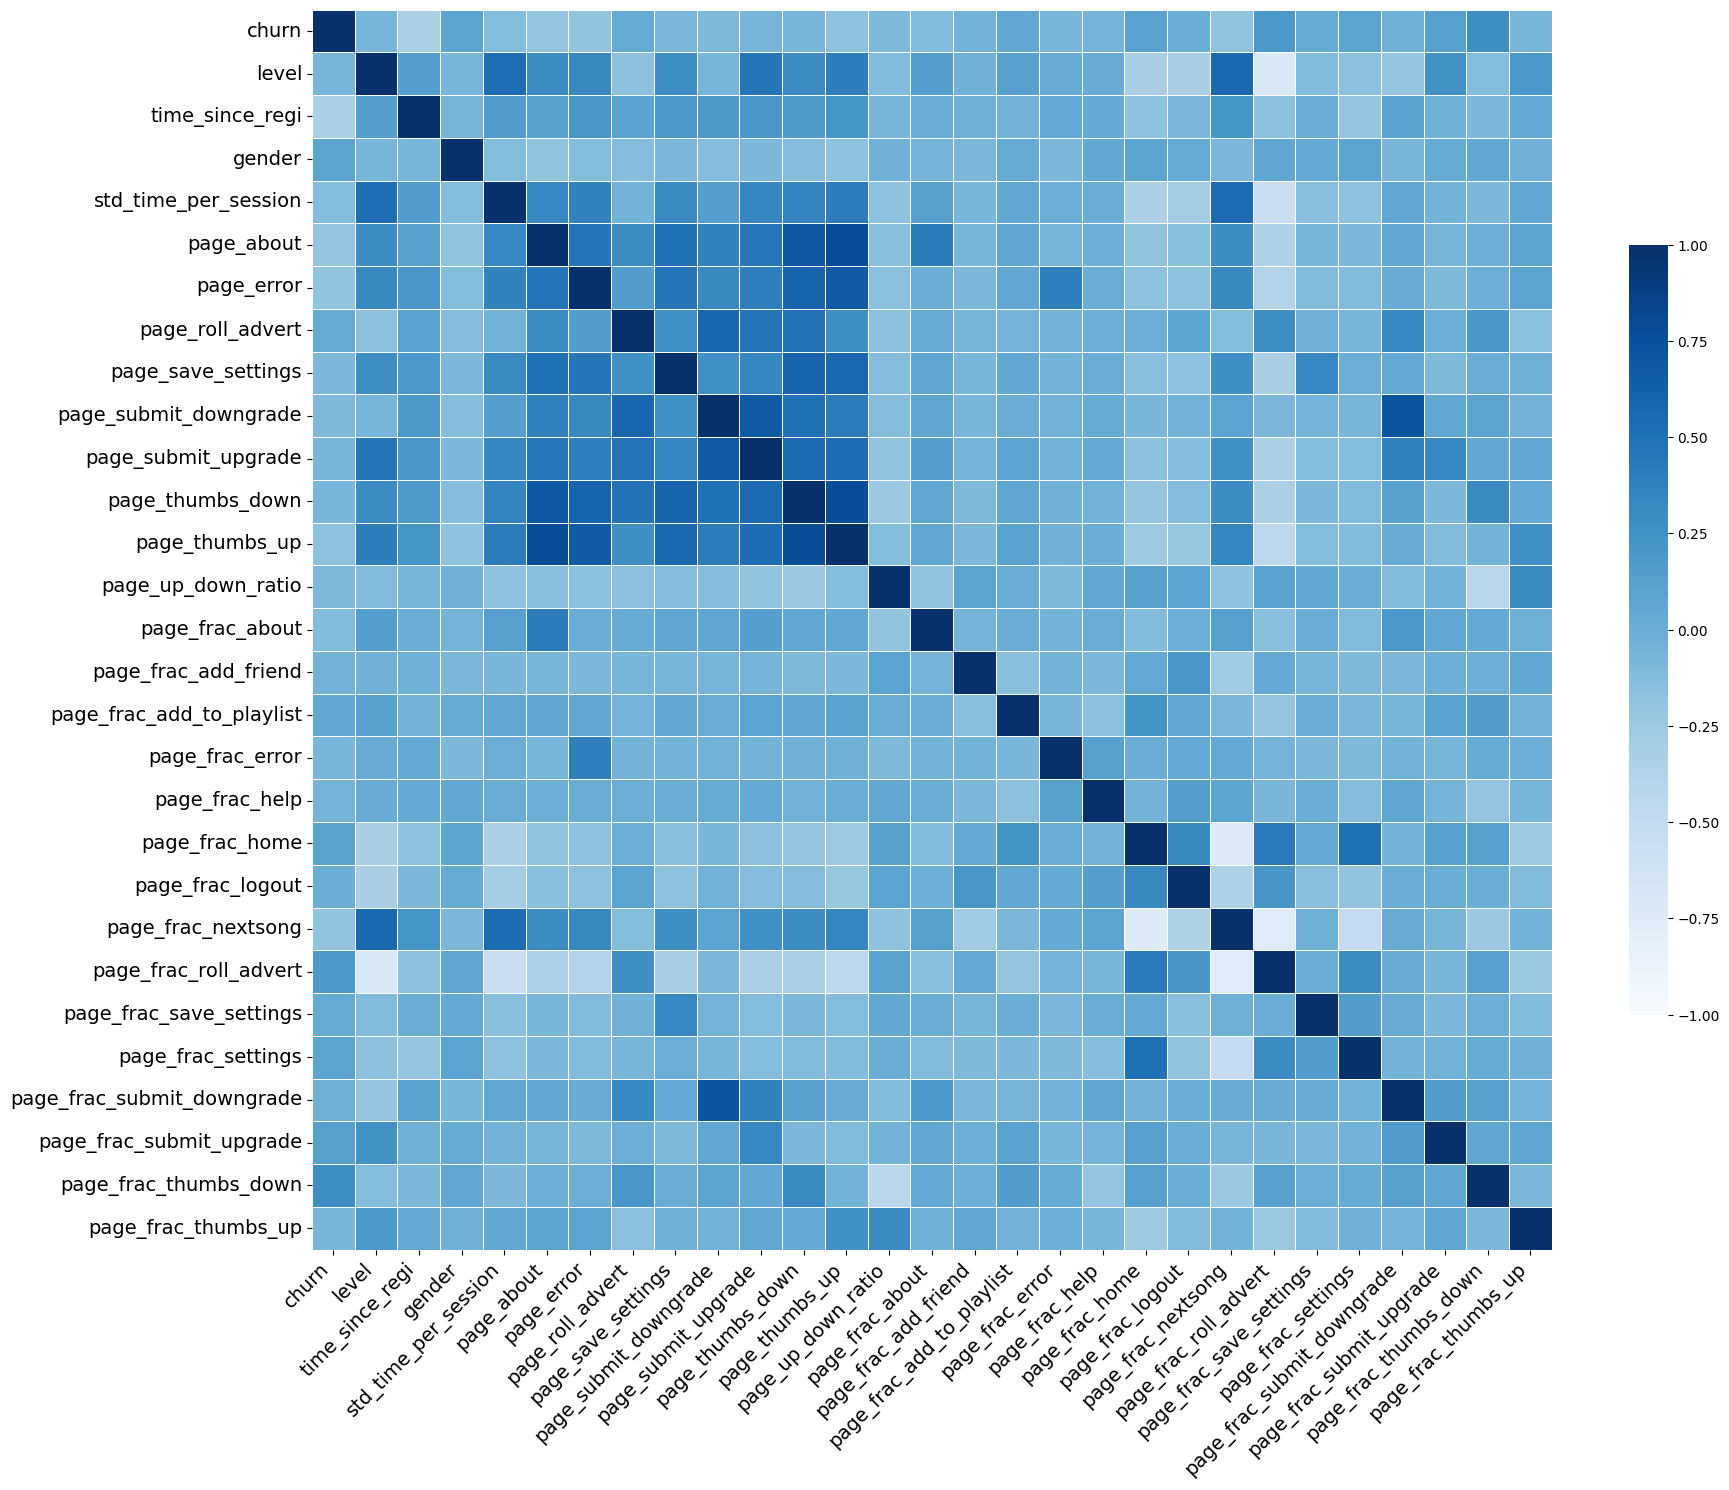

In [69]:
# Visualize correlations of the remaining features
print("Correlations among the remaining features:")
cols_to_keep_corr = [coln for coln in cols_to_keep if ('user_agent' not in coln) & ('userId' not in coln)]
corr_remaining = dataset_pd[cols_to_keep_corr].corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr_remaining, cmap='Blues', center=0,
    vmin=-1, vmax=1, 
    square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
    xticklabels=cols_to_keep_corr,
    yticklabels=cols_to_keep_corr,
#     annot=True
)
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(fontsize=14);
# ax.figure.axes[-1].yaxis.label.set_size(14)

There aren't extremely strong correlations (correlation coefficient >=0.8) left.

### 3.3. Feature transformation

#### Examine feature distributions

In [70]:
# Reset dataset
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(engagement, ['userId'])\
    .join(per_artist, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])

In [71]:
# Drop the highly correlated features
dataset = dataset.select(cols_to_keep)

In [72]:
cols_to_keep

['userId',
 'churn',
 'level',
 'time_since_regi',
 'gender',
 'std_time_per_session',
 'user_agent_Macintosh',
 'user_agent_Windows',
 'user_agent_X11',
 'user_agent_compatible',
 'user_agent_iPad',
 'user_agent_iPhone',
 'page_about',
 'page_error',
 'page_roll_advert',
 'page_save_settings',
 'page_submit_downgrade',
 'page_submit_upgrade',
 'page_thumbs_down',
 'page_thumbs_up',
 'page_up_down_ratio',
 'page_frac_about',
 'page_frac_add_friend',
 'page_frac_add_to_playlist',
 'page_frac_error',
 'page_frac_help',
 'page_frac_home',
 'page_frac_logout',
 'page_frac_nextsong',
 'page_frac_roll_advert',
 'page_frac_save_settings',
 'page_frac_settings',
 'page_frac_submit_downgrade',
 'page_frac_submit_upgrade',
 'page_frac_thumbs_down',
 'page_frac_thumbs_up']

In [73]:
# Convert to pandas
dataset_pd = dataset.toPandas()

In [74]:
# Confirm missing values
missing_value_count = dataset_pd.isnull().sum().sum()
print(f"{missing_value_count} missing value left.")

0 missing value left.


Examine feature distributions:


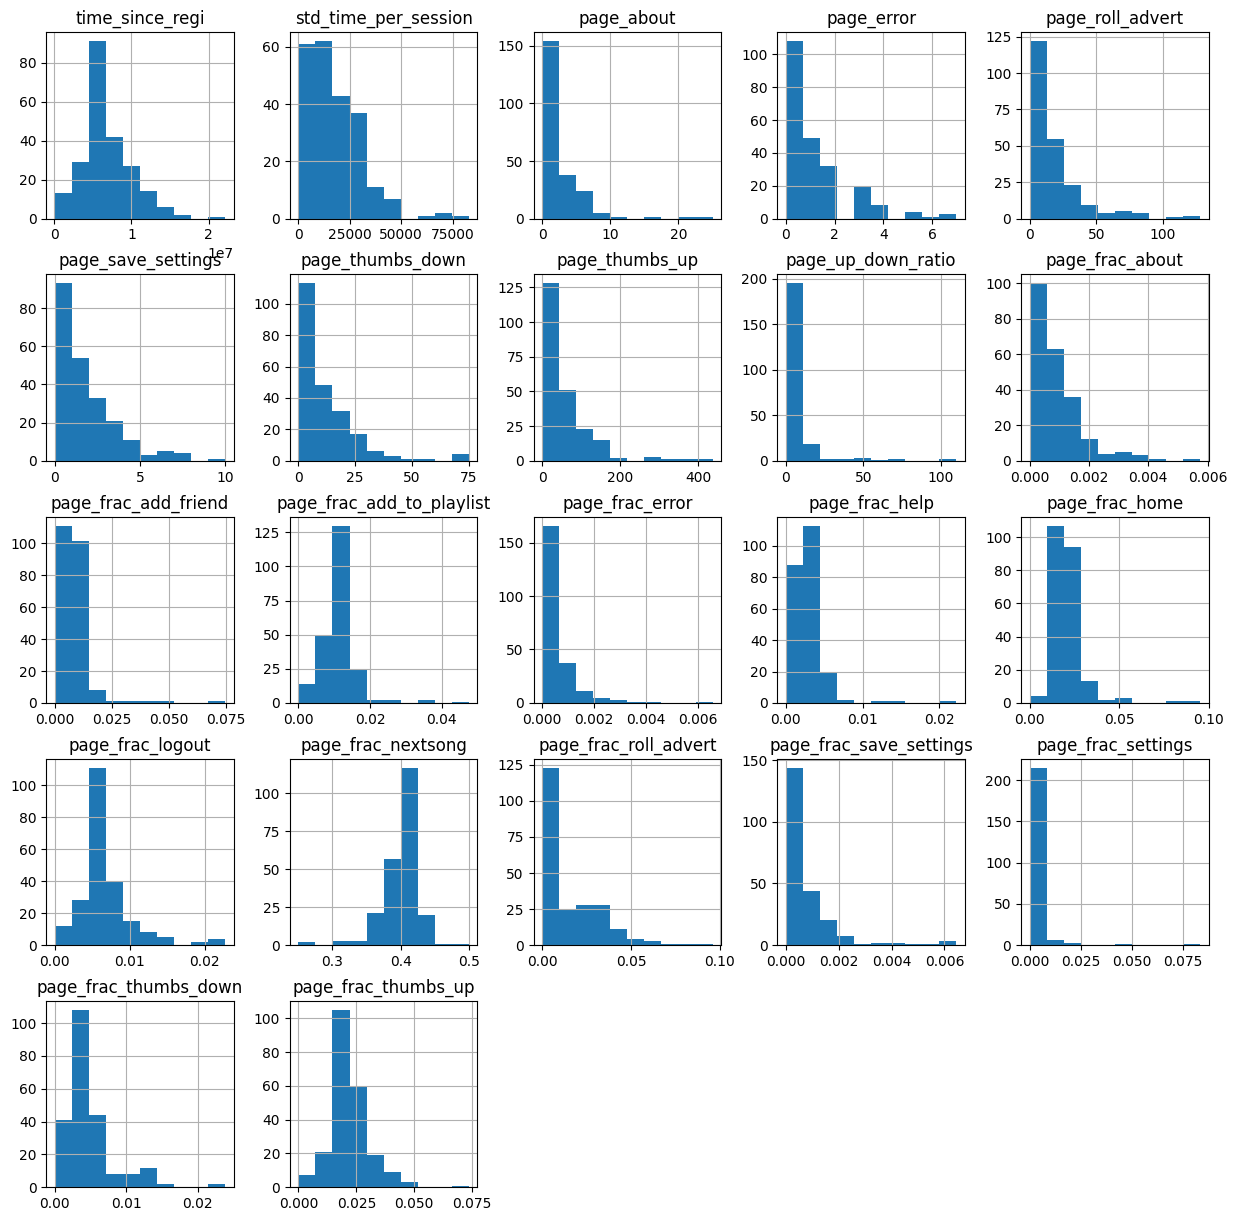

In [75]:
# Examine feature distributions (excluding binary features and submit page events)
print("Examine feature distributions:")
col_names = [coln for coln in dataset_pd.columns if 
             ('churn' not in coln) and 
             ('level' not in coln) and
             ('userId' not in coln) and
             ('gender' not in coln) and
             ('user_agent_' not in coln) and
             ('_submit_' not in coln)
            ]
dataset_pd[col_names].hist(figsize=(15,15));

### 3.4. Compile feature engineering code to scale up later

#### Load data

In [76]:
# Load from local source as a pilot study
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

#### Drop missing values

In [77]:
df = df.dropna(how='any', subset=['userId', 'sessionId'])
df = df.filter(df['userId'] != "")

#### Create features

In [78]:
df.createOrReplaceTempView("df_table")

# Define churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df.withColumn("churned", flag_churn_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(max('churned').alias("churn"))

# Latest level
func_levels = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
levels = df.select(['userId', 'level', 'ts'])\
    .orderBy(desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'level'])\
    .withColumn('level', func_levels('level').cast(IntegerType()))

# Time since registration in seconds, and gender as binary
time_gender = spark.sql(
    '''
    SELECT userId, (MAX(ts) - AVG(registration)) / 1000 time_since_regi,
    AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender
    FROM df_table
    GROUP BY userId
    '''
)

# Statistics of the time spent sper session (float)
per_session = spark.sql(
    '''
    SELECT userId, MAX(num_songs) max_songs_per_session, 
    AVG(num_songs) avg_songs_per_session, stddev_samp(num_songs) std_songs_per_session,
    MAX(time) max_time_per_session, AVG(time) avg_time_per_session, 
    stddev_samp(time) std_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM df_table
        GROUP BY userId, sessionId) per_session
    GROUP BY userId
    '''
).fillna(0)

In [79]:
# Calculate usage fraction of each userAgent
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0])

agents = df.withColumn("userAgent", func_agent_device(df["userAgent"]))\
    .select(["userId", 'userAgent'])\
    .groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage"))\
    .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)

# Count usages of each page event by each user
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']
func_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())
pages = df.filter(~df['page'].isin(pages_to_exclude))\
    .withColumn("page", func_pages(df["page"]))\
    .groupBy(['userId']).pivot("page").agg(count('page'))\
    .fillna(0)
pages = pages.withColumn("page_up_down_ratio", pages["page_thumbs_up"]/(pages['page_thumbs_down']+0.1))

# Calculate the fraction of each page event by each user
pages = pages.withColumn(
    'total', lit(0))

columns_to_sum = []
for coln in pages.columns: 
    if (coln != 'userId') and (coln != 'page_up_down_ratio'):
        columns_to_sum.append(coln)

for coln in columns_to_sum :
    pages = pages.withColumn('total', col('total') + col(coln) )
for coln in pages.columns:
    if coln not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = coln[0:5]+'frac_'+coln[5:]
        pages = pages.withColumn(new_col_name, pages[coln] / pages['total'])
pages = pages.drop('total')

#### Compile and transform features

In [80]:
# Join features together
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])

# Drop the highly correlated features
cols_to_keep = ['userId',
 'churn',
 'level',
 'time_since_regi',
 'gender',
 'avg_time_per_session',
 'std_time_per_session',
 'user_agent_Macintosh',
 'user_agent_Windows',
 'user_agent_X11',
 'user_agent_compatible',
 'user_agent_iPad',
 'user_agent_iPhone',
 'page_about',
 'page_error',
 'page_roll_advert',
 'page_save_settings',
 'page_settings',
 'page_submit_downgrade',
 'page_submit_upgrade',
 'page_thumbs_down',
 'page_thumbs_up',
 'page_up_down_ratio',
 'page_frac_about',
 'page_frac_add_friend',
 'page_frac_add_to_playlist',
 'page_frac_error',
 'page_frac_help',
 'page_frac_home',
 'page_frac_logout',
 'page_frac_nextsong',
 'page_frac_roll_advert',
 'page_frac_save_settings',
 'page_frac_settings',
 'page_frac_submit_downgrade',
 'page_frac_submit_upgrade',
 'page_frac_thumbs_down',
 'page_frac_thumbs_up']


dataset = dataset.select(cols_to_keep)


In [81]:
# Confirm missing values
dataset_pd = dataset.toPandas()
missing_value_count = dataset_pd.isnull().sum().sum()
print(f"{missing_value_count} missing value left.")

0 missing value left.


## 4. Modeling

### 4.1. Train-test split

In [82]:
# Rename churn column into label
dataset = dataset.withColumn('label', dataset['churn'].cast('float')).drop('churn') #important to have float type

# Feature columns to be converted into vector
feature_cols = dataset.drop('label').drop('userId').columns

In [83]:
# Train-test split
train, test = dataset.drop('userId').randomSplit([0.8, 0.2], seed=42)

In [84]:
train.show(1)

+-----+---------------+------+--------------------+--------------------+--------------------+------------------+--------------+---------------------+---------------+-----------------+----------+----------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+---------------+--------------------+-------------------------+---------------+--------------+-------------------+----------------+------------------+---------------------+-----------------------+-------------------+--------------------------+------------------------+---------------------+-------------------+-----+
|level|time_since_regi|gender|avg_time_per_session|std_time_per_session|user_agent_Macintosh|user_agent_Windows|user_agent_X11|user_agent_compatible|user_agent_iPad|user_agent_iPhone|page_about|page_error|page_roll_advert|page_save_settings|page_settings|page_submit_downgrade|page_submit_upgrade|page_thumbs_down|page_thumbs_up|page_u

In [85]:
train.printSchema()

root
 |-- level: integer (nullable = true)
 |-- time_since_regi: double (nullable = true)
 |-- gender: double (nullable = true)
 |-- avg_time_per_session: double (nullable = false)
 |-- std_time_per_session: double (nullable = false)
 |-- user_agent_Macintosh: double (nullable = false)
 |-- user_agent_Windows: double (nullable = false)
 |-- user_agent_X11: double (nullable = false)
 |-- user_agent_compatible: double (nullable = false)
 |-- user_agent_iPad: double (nullable = false)
 |-- user_agent_iPhone: double (nullable = false)
 |-- page_about: long (nullable = true)
 |-- page_error: long (nullable = true)
 |-- page_roll_advert: long (nullable = true)
 |-- page_save_settings: long (nullable = true)
 |-- page_settings: long (nullable = true)
 |-- page_submit_downgrade: long (nullable = true)
 |-- page_submit_upgrade: long (nullable = true)
 |-- page_thumbs_down: long (nullable = true)
 |-- page_thumbs_up: long (nullable = true)
 |-- page_up_down_ratio: double (nullable = true)
 |-- p

### 4.2. Evaluation metric

It's important to note that churned users constitute a relatively small portion of the dataset, accounting for only 23% of the total, with the remaining 77% being non-churned users.

When assessing model performance using accuracy as the evaluation metric, a model that merely predicts "no-churn" for all instances would achieve a relatively high accuracy of 77%. However, this seemingly high accuracy would be misleading because such a model would completely fail to identify any actual instances of churn. Therefore, accuracy alone is not a suitable metric for our analysis in this context.

Instead, I have opted to utilize the F1 score as our primary evaluation metric. The F1 score strikes a balance between precision and recall, making it well-suited for scenarios like ours. In the context of the F1 score:

$$F_1 = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

Here, precision is concerned with ensuring that when the model predicts churn, it is indeed a genuine churn event. On the other hand, recall aims to minimize the number of actual churn events that go undetected. By utilizing the F1 score, we can assess our model's performance in a more balanced and informative manner, taking both false positives and false negatives into account.

### 4.3. Pipeline and functions

- Build cross validation pipeline
- Train a machine learning model
- Evaluate model performance

`MinMaxScaler` is chosen for feature scaling, because it is able to rescale each feature to range [0, 1] for all the features 

In [86]:
def buildCV(classifier, paramGrid):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: cross validator
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MinMaxScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=4,
        collectSubModels=True,
    )
    return crossval

def trainModel(classifier, train_data, paramGrid):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (Spark dataframe): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    crossval = buildCV(classifier, paramGrid)
    start = time()
    model = crossval.fit(train_data)
    end = time()
    training_time = end - start
    return model, training_time

def evaluateModel(model, data):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (Spark dataframe): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics
    '''
    # Calculate metrics
    true_labels = [row.label for row in data.select('label').collect()]
    predicted_labels = [row.prediction for row in model.transform(data).collect()]
    
    
    # Generate the classification report
    report = classification_report(true_labels, predicted_labels)
    

    return report


### 4.4. Initial model evaluation

Compare performance of different models using default hyperparameters.

#### Baseline model

Define a naive model that always predicts no-churn, aka., label=0. I'm going to calculate F1 score and accuracy score of this naive model to set a baseline of model performance. The tuned machine learning model should be able to achieve better performance.

In [87]:
# Make prediction
pred = dataset.select("label").withColumn("prediction", lit(0.0))

In [88]:
# Assuming 'pred' is your DataFrame containing predictions
true_labels = [row.label for row in pred.select('label').collect()]
predicted_labels = [row.prediction for row in pred.select('prediction').collect()]

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       173
         1.0       0.00      0.00      0.00        52

    accuracy                           0.77       225
   macro avg       0.38      0.50      0.43       225
weighted avg       0.59      0.77      0.67       225



/home/faisal/miniconda3/envs/Sparkify/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/faisal/miniconda3/envs/Sparkify/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/faisal/miniconda3/envs/Sparkify/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

#### Logistic Regression

In [89]:
# Train the model and evaluate performance
classifier = LogisticRegression(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
model,_ = trainModel(classifier, train, paramGrid)

23/09/19 10:28:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [90]:
model.bestModel.write().overwrite().save("LR/")

In [91]:
# # load model

# from pyspark.ml import PipelineModel
# model = PipelineModel.load("LR")

In [92]:
model.bestModel.stages[-1].summary.weightedFMeasure() # on training all data 
# because pyspark chooses the best model with average specific hyper-parameters across folds, then trains it on the entire training data 

0.863904923599321

In [93]:
print(evaluateModel(model, train))

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92       148
         1.0       0.82      0.55      0.66        42

    accuracy                           0.87       190
   macro avg       0.85      0.76      0.79       190
weighted avg       0.87      0.87      0.86       190



In [94]:
# lets see the performance of all the cv k-folds

f1_scores = np.array([])
for i in range(len(model.subModels)):
    f1_scores = np.append(f1_scores , model.subModels[i][0].stages[-1].summary.weightedFMeasure() ) 

print('Average weightedFMeasure :', f1_scores.mean(), ' +- ', f1_scores.std() )

Average weightedFMeasure : 0.8937888540622194  +-  0.016126648637504546


In [95]:
print(evaluateModel(model, test))

              precision    recall  f1-score   support

         0.0       0.76      0.88      0.81        25
         1.0       0.50      0.30      0.37        10

    accuracy                           0.71        35
   macro avg       0.63      0.59      0.59        35
weighted avg       0.68      0.71      0.69        35



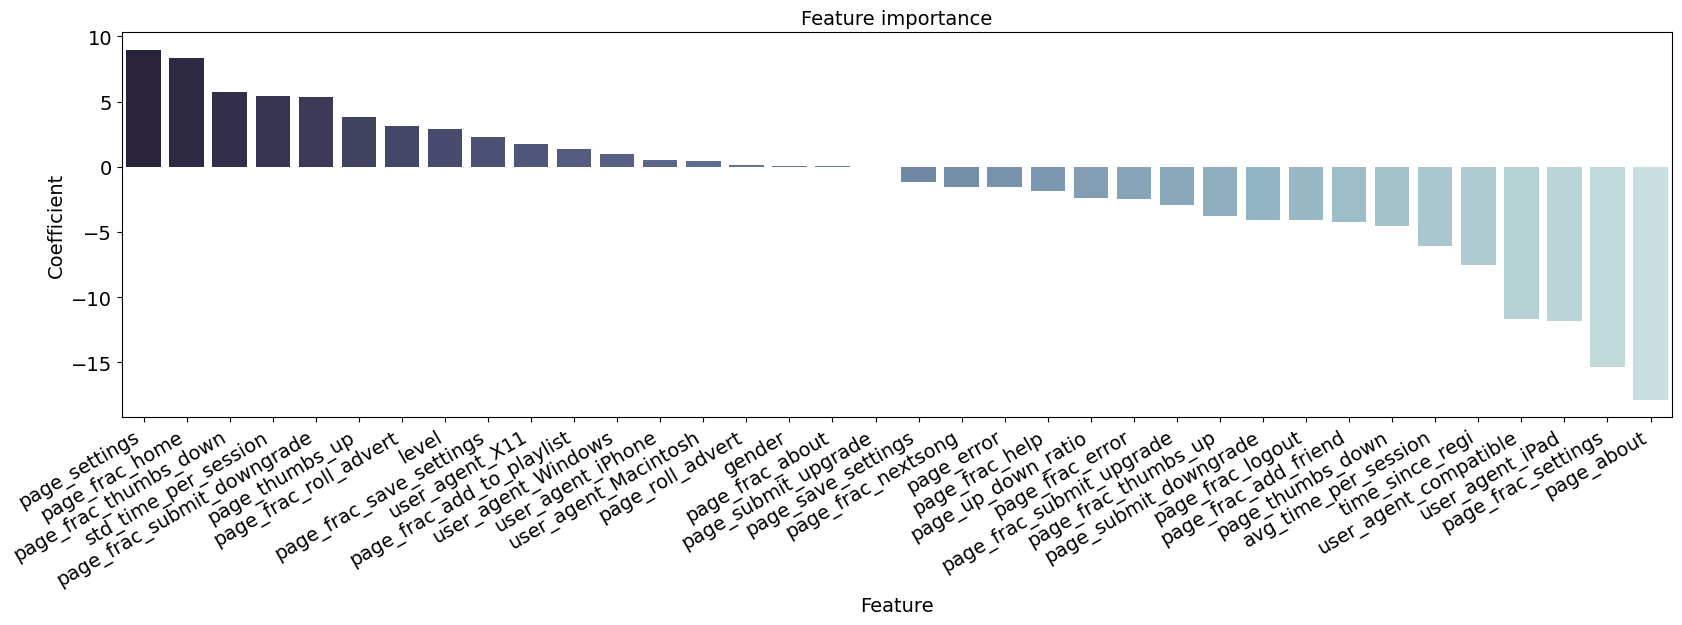

In [96]:
# Feature importance
feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df, palette="ch:start=.2,rot=-.3_r")  # Set palette to 'Blues'
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);


#### Random Forest

In [97]:
# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
model,_ = trainModel(classifier, train, paramGrid)



In [98]:
model.bestModel.write().overwrite().save("RF/")

In [99]:
# # load model

# from pyspark.ml import PipelineModel
# model = PipelineModel.load("RF")

In [100]:
model.bestModel.stages[-1].summary.weightedFMeasure() # on training all data 
# because pyspark chooses the best model with average specific hyper-parameters across folds, then trains it on the entire training data 

0.9328092959671908

In [101]:
print(evaluateModel(model, train))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       148
         1.0       1.00      0.71      0.83        42

    accuracy                           0.94       190
   macro avg       0.96      0.86      0.90       190
weighted avg       0.94      0.94      0.93       190



In [102]:
# lets see the performance of all the cv k-folds

f1_scores = np.array([])
for i in range(len(model.subModels)):
    f1_scores = np.append(f1_scores , model.subModels[i][0].stages[-1].summary.weightedFMeasure() ) 

print('Average weightedFMeasure :', f1_scores.mean(), ' +- ', f1_scores.std() )

Average weightedFMeasure : 0.9521082864896953  +-  0.006946508291468404


In [103]:
print(evaluateModel(model, test))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86        25
         1.0       1.00      0.20      0.33        10

    accuracy                           0.77        35
   macro avg       0.88      0.60      0.60        35
weighted avg       0.83      0.77      0.71        35



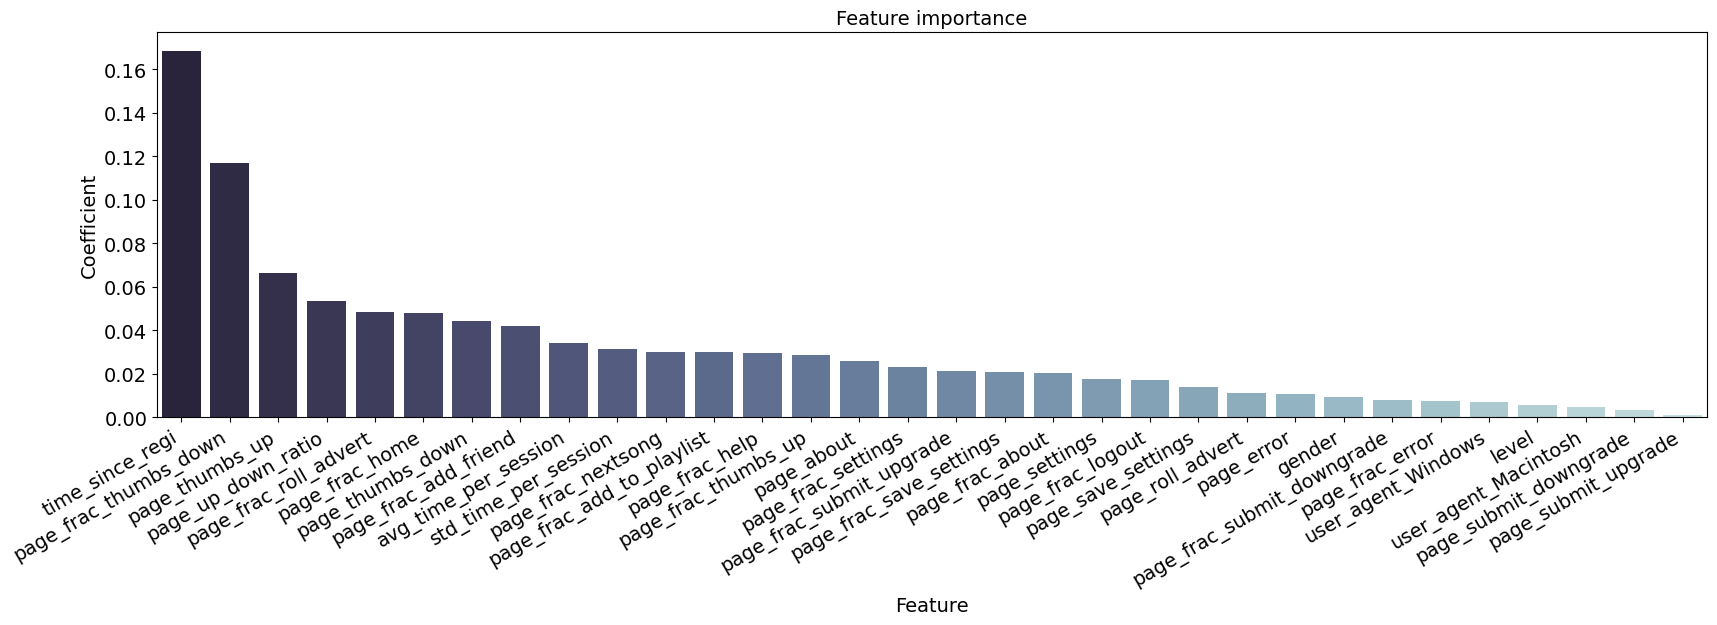

In [104]:

# Feature importance
feature_ind = model.bestModel.stages[2].featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = model.bestModel.stages[2].featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df, palette="ch:start=.2,rot=-.3_r")  # Set palette to 'Blues'
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);


#### Gradient-Boosted Tree

In [105]:
# Train the model and evaluate performance
classifier = GBTClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
model,_ = trainModel(classifier, train, paramGrid)


In [106]:
model.bestModel.write().overwrite().save("GBT/")

In [107]:
# #load model

# from pyspark.ml import PipelineModel
# model = PipelineModel.load("GBT")

pyspark doesnt provide a staright forward way of accessing the gradient boosted tree model performance during training, and among folds

In [108]:
print(evaluateModel(model, train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       148
         1.0       1.00      1.00      1.00        42

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



In [109]:
print(evaluateModel(model, test))

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81        25
         1.0       0.50      0.40      0.44        10

    accuracy                           0.71        35
   macro avg       0.64      0.62      0.63        35
weighted avg       0.70      0.71      0.70        35



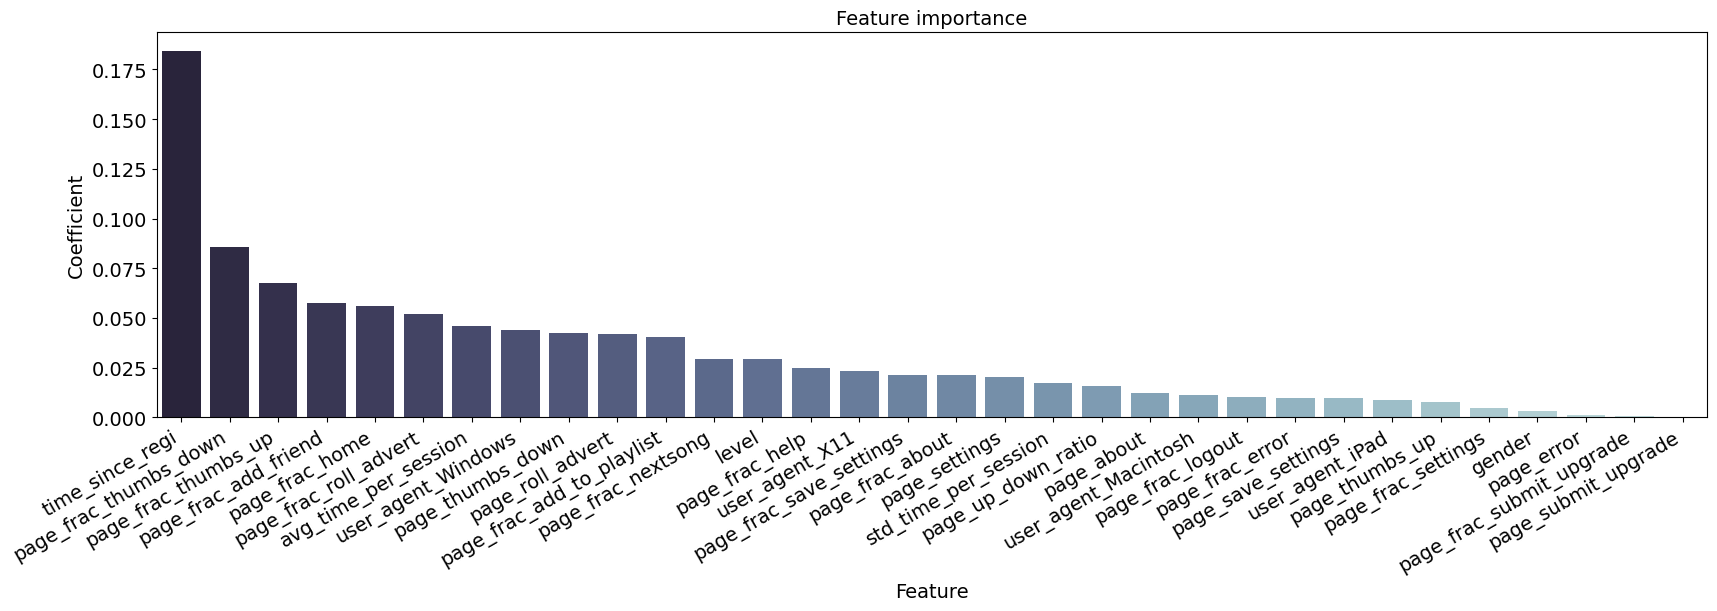

In [110]:

# Feature importance
feature_ind = model.bestModel.stages[2].featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = model.bestModel.stages[2].featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df, palette="ch:start=.2,rot=-.3_r")  # Set palette to 'Blues'
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);



### Tuning the gradient boosted tree model 

In [ ]:
# Train the model and evaluate performance
classifier = GBTClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid = ParamGridBuilder()\
      .addGrid(classifier.minInstancesPerNode, [1, 5, 10])\
      .addGrid(classifier.maxDepth, [1, 5,9])\
      .addGrid(classifier.maxIter, [50, 100])\
      .build()

model,_ = trainModel(classifier, train, paramGrid)


In [ ]:
model.bestModel.write().overwrite().save("Tuned_GBT/")

In [111]:
from pyspark.ml import PipelineModel
model = PipelineModel.load("Tuned_GBT")

In [112]:
params = model.stages[-1].extractParamMap()
for param, value in params.items():
    print(f"{param.name}: {value}")

cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: scaledFeatures
impurity: variance
labelCol: label
leafCol: 
lossType: logistic
maxBins: 32
maxDepth: 1
maxIter: 100
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 5
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 1446326476551102916
stepSize: 0.1
subsamplingRate: 1.0
validationTol: 0.01


In [113]:
print(evaluateModel(model, train))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       148
         1.0       0.89      0.60      0.71        42

    accuracy                           0.89       190
   macro avg       0.89      0.79      0.82       190
weighted avg       0.89      0.89      0.89       190



In [114]:
print(evaluateModel(model, test))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88        25
         1.0       1.00      0.30      0.46        10

    accuracy                           0.80        35
   macro avg       0.89      0.65      0.67        35
weighted avg       0.84      0.80      0.76        35



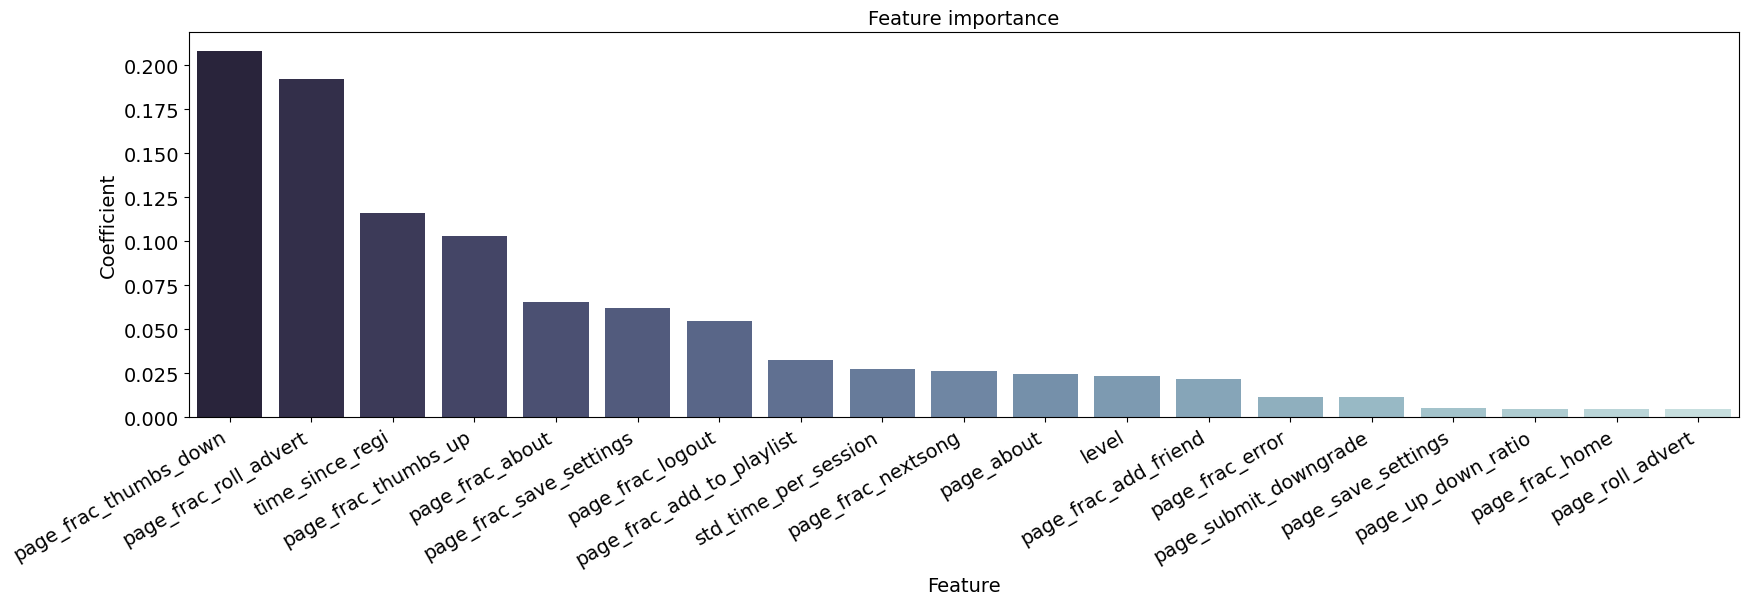

In [115]:
# Feature importance
feature_ind = model.stages[2].featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = model.stages[2].featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df   , palette="ch:start=.2,rot=-.3_r")
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

#### examine PR Curve of the tuned GBT model : 

In [116]:
from pyspark.sql.types import FloatType

def get_probability(x):
    return float(x[1])

get_probability_udf = udf(get_probability, FloatType())



#### PR Curve on training set

AUC-PR: 0.8408


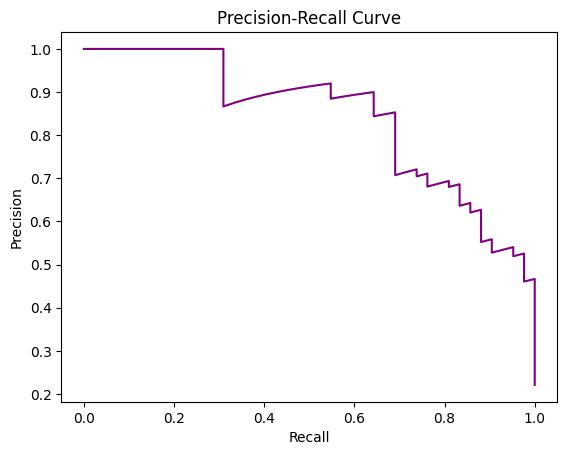

In [117]:
predictions = model.transform(train).select('label','probability', 'prediction').withColumn('prediction_probability', get_probability_udf(col('probability'))).select('label', 'prediction_probability', 'prediction')

predictions=predictions.select('prediction_probability','label').toPandas()
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(predictions['label'], predictions['prediction_probability'])
auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr:.4f}')

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

#### PR Curve on testing set

AUC-PR: 0.7585


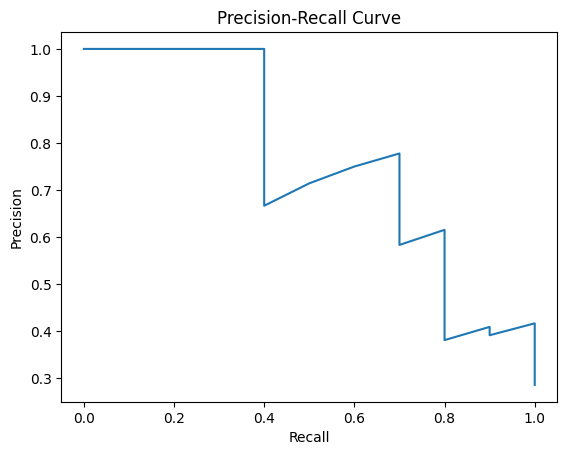

In [118]:
predictions = model.transform(test).select('label','probability', 'prediction').withColumn('prediction_probability', get_probability_udf(col('probability'))).select('label', 'prediction_probability', 'prediction')

predictions=predictions.select('prediction_probability','label').toPandas()
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(predictions['label'], predictions['prediction_probability'])

auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr:.4f}')

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision)

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Conclusion : 


- The naive model sets a baseline of model performance, Weighted F1 = 0.67 and accuracy = 0.77. As expected, the three machine learning classifiers can perform better than the naive model on the training set. 

- Logestic Regression achieves (F1 = 0.86, accuracy = 0.87) on the training set , and achieves (F1 = 0.69 accuracy = 0.71) on the testing set . 

- Random Forest achieves (F1 = 0.93, accuracy = 0.93) on the training set, and achieves (F1 = 0.65 accuracy = 0.74) on the testing set . 

- Gradient-Boosted Tree takes longest time to train, achieves (F1 = 0.89, accuracy = 0.89) on the training set , and achieves best performance (after tuning) on the testing set (F1 = 0.76, accuracy = 0.80).
it also acheives AUC-PR: 0.8408 on the training set, and AUC-PR: 0.7585 on the testing set. 
